## Assessing Differences Between Groups

In [1]:
import pandas as pd
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Get data loaded back on this script 
df_filtered2_norm_log = pd.read_csv('data/df_filtered2_norm_log.tsv', sep='\t') 

# Re-do the following to get them back on this script
## Group columns based on their location (e.g., CITO_, MEMB_, NUC_) and ensure they end with '_MaxLFQIntensity'
cito_cols = [col for col in df_filtered2_norm_log.columns if col.startswith('CITO_') and col.endswith('_MaxLFQIntensity')]
memb_cols = [col for col in df_filtered2_norm_log.columns if col.startswith('MEMB_') and col.endswith('_MaxLFQIntensity')]
nuc_cols = [col for col in df_filtered2_norm_log.columns if col.startswith('NUC_') and col.endswith('_MaxLFQIntensity')]

## Combine all columns into a dictionary by group for easier plotting
compartments = {
    'CITO': cito_cols,
    'MEMB': memb_cols,
    'NUC': nuc_cols
}

In [33]:
print(df_filtered2_norm_log.head())
print(cito_cols)
print(memb_cols)
print(nuc_cols)
print(compartments)

                 Protein Protein_ID   Entry_Name      Gene  Protein_Length  \
0   sp|A6NEC2|PSAL_HUMAN     A6NEC2   PSAL_HUMAN  NPEPPSL1           478.0   
1  sp|A8MWD9|RUXGL_HUMAN     A8MWD9  RUXGL_HUMAN  SNRPGP15            76.0   
2  sp|E9PAV3|NACAM_HUMAN     E9PAV3  NACAM_HUMAN      NACA          2078.0   
3  sp|O00148|DX39A_HUMAN     O00148  DX39A_HUMAN    DDX39A           427.0   
4  sp|O00186|STXB3_HUMAN     O00186  STXB3_HUMAN    STXBP3           592.0   

       Organism                            Protein_Existence  \
0  Homo sapiens  2:Experimental evidence at transcript level   
1  Homo sapiens                          5:Protein uncertain   
2  Homo sapiens     1:Experimental evidence at protein level   
3  Homo sapiens     1:Experimental evidence at protein level   
4  Homo sapiens     1:Experimental evidence at protein level   

                                         Description  Protein_Probability  \
0    Puromycin-sensitive aminopeptidase-like protein               0.

In [5]:
# Computing differences between control and EGF treatment 

## Kruskal-Wallis test function
def kruskal_test_between_conditions(compartments, condition1='_CTRL_', condition2='_EGF_'):
    results = {}
    
    for group, cols in compartments.items():
        # Filter columns based on the condition
        ctrl_cols = [col for col in cols if condition1 in col]
        egf_cols = [col for col in cols if condition2 in col]
        
        if ctrl_cols and egf_cols:
            # Extract data for each condition and compartment
            ctrl_data = df_filtered2_norm_log[ctrl_cols].values.flatten()  # Flatten to a 1D array
            egf_data = df_filtered2_norm_log[egf_cols].values.flatten()  # Flatten to a 1D array
            
            # Perform Kruskal-Wallis test
            stat, p_value = kruskal(ctrl_data, egf_data)
            results[group] = {
                'Kruskal-Wallis Statistic': stat,
                'p-value': p_value
            }
            
            # Display results
            print(f'{group} Compartment - Kruskal-Wallis Test:')
            print(f'Kruskal-Wallis Statistic: {stat:.3f}')
            print(f'p-value: {p_value:.3e}\n')
        else:
            print(f'Not enough data in {group} compartment to perform the test.')
    
    return results

# Run Kruskal-Wallis test for each compartment
kruskal_results = kruskal_test_between_conditions(compartments)

CITO Compartment - Kruskal-Wallis Test:
Kruskal-Wallis Statistic: 0.957
p-value: 3.279e-01

MEMB Compartment - Kruskal-Wallis Test:
Kruskal-Wallis Statistic: 58.803
p-value: 1.742e-14

NUC Compartment - Kruskal-Wallis Test:
Kruskal-Wallis Statistic: 18.032
p-value: 2.172e-05



In [6]:
# !pip install scikit-posthocs 

In [11]:
import scikit_posthocs as sp

# Filter the data for MEMB and NUC compartments; melt = long format
df_memb = df_filtered2_norm_log[[col for col in df_filtered2_norm_log.columns if col.startswith('MEMB_') and col.endswith('_MaxLFQIntensity')]]
df_nuc = df_filtered2_norm_log[[col for col in df_filtered2_norm_log.columns if col.startswith('NUC_') and col.endswith('_MaxLFQIntensity')]]

# Melt dataframes for compatibility with Dunn's test
df_memb_melted = df_memb.melt(var_name="Condition", value_name="LogNormalizedValue")
df_nuc_melted = df_nuc.melt(var_name="Condition", value_name="LogNormalizedValue")

print(df_memb_melted.head())

print(df_nuc_melted.head())

                      Condition  LogNormalizedValue
0  MEMB_CTRL_R1_MaxLFQIntensity                 0.0
1  MEMB_CTRL_R1_MaxLFQIntensity                 0.0
2  MEMB_CTRL_R1_MaxLFQIntensity                 0.0
3  MEMB_CTRL_R1_MaxLFQIntensity                 0.0
4  MEMB_CTRL_R1_MaxLFQIntensity                 0.0
                     Condition  LogNormalizedValue
0  NUC_CTRL_R1_MaxLFQIntensity            0.008386
1  NUC_CTRL_R1_MaxLFQIntensity            0.026602
2  NUC_CTRL_R1_MaxLFQIntensity            0.032488
3  NUC_CTRL_R1_MaxLFQIntensity            0.030143
4  NUC_CTRL_R1_MaxLFQIntensity            0.000000


In [12]:
# Perform Dunn's test for MEMB and NUC
dunn_memb = sp.posthoc_dunn(df_memb_melted, val_col="LogNormalizedValue", group_col="Condition", p_adjust='bonferroni')
dunn_nuc = sp.posthoc_dunn(df_nuc_melted, val_col="LogNormalizedValue", group_col="Condition", p_adjust='bonferroni')

# Print results
print("Dunn's Test Results for MEMB Compartment (Bonferroni-adjusted p-values):")
dunn_memb

print("\nDunn's Test Results for NUC Compartment (Bonferroni-adjusted p-values):")
dunn_nuc

Dunn's Test Results for MEMB Compartment (Bonferroni-adjusted p-values):

Dunn's Test Results for NUC Compartment (Bonferroni-adjusted p-values):


,NUC_CTRL_R1_MaxLFQIntensity,NUC_CTRL_R2_MaxLFQIntensity,NUC_EGF_R1_MaxLFQIntensity,NUC_EGF_R2_MaxLFQIntensity
NUC_CTRL_R1_MaxLFQIntensity,1.000000,1.000000,0.025825,0.000521
NUC_CTRL_R2_MaxLFQIntensity,1.000000,1.000000,0.224791,0.009783
NUC_EGF_R1_MaxLFQIntensity,0.025825,0.224791,1.000000,1.000000
NUC_EGF_R2_MaxLFQIntensity,0.000521,0.009783,1.000000,1.000000


/tmp/ipykernel_56856/2660120854.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_to_plot, x='Column', y='LogNormalizedValue', palette='Set2')
/tmp/ipykernel_56856/2660120854.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_to_plot, x='Column', y='LogNormalizedValue', palette='Set2')
/tmp/ipykernel_56856/2660120854.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_to_plot, x='Column', y='LogNormalizedValue', palette='Set2')


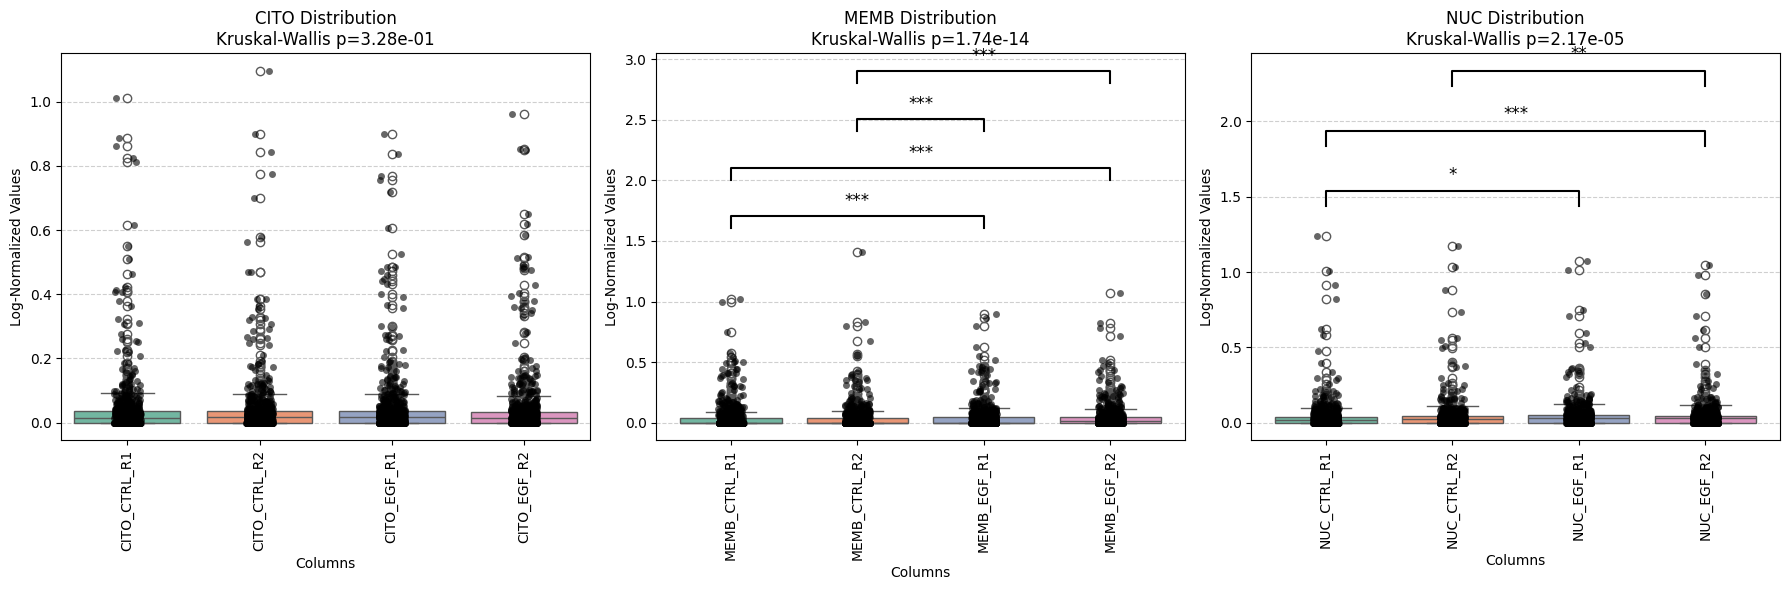

In [13]:
# Kruskal-Wallis and Dunn test results to annotate
kruskal_results = {
    'CITO': (0.957, 0.3279),
    'MEMB': (58.803, 1.742e-14),
    'NUC': (18.032, 2.172e-05)
}

dunn_results = {
    'MEMB': {
        ('MEMB_CTRL_R1_MaxLFQIntensity', 'MEMB_EGF_R1_MaxLFQIntensity'): 1.110216e-06,
        ('MEMB_CTRL_R1_MaxLFQIntensity', 'MEMB_EGF_R2_MaxLFQIntensity'): 5.910738e-08,
        ('MEMB_CTRL_R2_MaxLFQIntensity', 'MEMB_EGF_R1_MaxLFQIntensity'): 1.918779e-06,
        ('MEMB_CTRL_R2_MaxLFQIntensity', 'MEMB_EGF_R2_MaxLFQIntensity'): 1.075717e-07
    },
    'NUC': {
        ('NUC_CTRL_R1_MaxLFQIntensity', 'NUC_EGF_R1_MaxLFQIntensity'): 0.025825,
        ('NUC_CTRL_R1_MaxLFQIntensity', 'NUC_EGF_R2_MaxLFQIntensity'): 0.000521,
        ('NUC_CTRL_R2_MaxLFQIntensity', 'NUC_EGF_R2_MaxLFQIntensity'): 0.009783
    }
}

# Function to generate labels by removing the '_MaxLFQIntensity' suffix
def generate_column_labels(cols):
    return [col.replace('_MaxLFQIntensity', '') for col in cols]

# Significance level function for easy marking
def get_significance_label(pval):
    if pval < 0.001:
        return "***"
    elif pval < 0.01:
        return "**"
    elif pval < 0.05:
        return "*"
    return "ns"

# Function to plot boxplots with significance annotations
def plot_boxplots_with_annotations(compartments, kruskal_results, dunn_results):
    plt.figure(figsize=(18, 6))  # Adjust figure size for three compartments

    for i, (group, cols) in enumerate(compartments.items(), 1):
        plt.subplot(1, 3, i)  # 1 row, 3 columns for compartments
        data_to_plot = df_filtered2_norm_log[cols].melt(var_name='Column', value_name='LogNormalizedValue')

        # Plot box plot
        sns.boxplot(data=data_to_plot, x='Column', y='LogNormalizedValue', palette='Set2')
        
        # Add dots to show individual data points
        sns.stripplot(data=data_to_plot, x='Column', y='LogNormalizedValue', color='black', alpha=0.6, jitter=True)

        # Kruskal-Wallis p-value annotation
        kw_stat, kw_pval = kruskal_results[group]
        plt.title(f'{group} Distribution\nKruskal-Wallis p={kw_pval:.2e}')
        
        # Dunn's test annotations for specific pairwise comparisons
        if group in dunn_results:
            y_max = data_to_plot['LogNormalizedValue'].max()  # Get max y-value to position annotations
            for (col1, col2), pval in dunn_results[group].items():
                x1, x2 = cols.index(col1), cols.index(col2)
                y = y_max + 0.2  # Adjust spacing for each comparison

                # Draw the annotation line for significant comparisons
                plt.plot([x1, x1, x2, x2], [y, y + 0.1, y + 0.1, y], lw=1.5, color='black')

                # Add significance label
                sig_text = get_significance_label(pval)
                plt.text((x1 + x2) * 0.5, y + 0.15, sig_text, ha='center', va='bottom', color="black", fontsize=12)
                
                # Update y_max for next annotation position
                y_max += 0.4

        # Rotate x labels for better readability using simplified labels
        simplified_labels = generate_column_labels(cols)
        tick_positions = range(len(cols))  # Set tick positions as the range of column indices
        plt.xticks(tick_positions, labels=simplified_labels, rotation=90)
        
        # Labels and grid
        plt.xlabel('Columns')
        plt.ylabel('Log-Normalized Values')
        plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Plot with significance annotations
plot_boxplots_with_annotations(compartments, kruskal_results, dunn_results)

In [17]:
# Re-do previous plots using mean intensity values for replicas
# Calculate the mean of R1 and R2 for CTRL and EGF conditions for each protein
mean_cols = {
    'CITO': ['CITO_CTRL_R1_MaxLFQIntensity', 'CITO_CTRL_R2_MaxLFQIntensity', 'CITO_EGF_R1_MaxLFQIntensity', 'CITO_EGF_R2_MaxLFQIntensity'],
    'MEMB': ['MEMB_CTRL_R1_MaxLFQIntensity', 'MEMB_CTRL_R2_MaxLFQIntensity', 'MEMB_EGF_R1_MaxLFQIntensity', 'MEMB_EGF_R2_MaxLFQIntensity'],
    'NUC': ['NUC_CTRL_R1_MaxLFQIntensity', 'NUC_CTRL_R2_MaxLFQIntensity', 'NUC_EGF_R1_MaxLFQIntensity', 'NUC_EGF_R2_MaxLFQIntensity']
}

# Compute mean values for each compartment by averaging R1 and R2 for both CTRL and EGF
df_mean = df_filtered2_norm_log.copy()

for comp, cols in mean_cols.items():
    # Calculate mean for CTRL and EGF
    df_mean[f'{comp}_CTRL_Mean'] = df_filtered2_norm_log[[cols[0], cols[1]]].mean(axis=1)
    df_mean[f'{comp}_EGF_Mean'] = df_filtered2_norm_log[[cols[2], cols[3]]].mean(axis=1)

# Update compartments dictionary to use the new mean columns
compartments_mean = {
    'CITO': ['CITO_CTRL_Mean', 'CITO_EGF_Mean'],
    'MEMB': ['MEMB_CTRL_Mean', 'MEMB_EGF_Mean'],
    'NUC': ['NUC_CTRL_Mean', 'NUC_EGF_Mean']
}
print(compartments_mean)

# Print the actual mean values calculated for each compartment
print("\nMean intensity values for each condition and compartment:")
for comp in compartments_mean:
    print(f"\n{comp} Compartment:")
    for col in compartments_mean[comp]:
        print(f"{col}:\n{df_mean[col].head()}\n")  # Display the first few mean values for each column

{'CITO': ['CITO_CTRL_Mean', 'CITO_EGF_Mean'], 'MEMB': ['MEMB_CTRL_Mean', 'MEMB_EGF_Mean'], 'NUC': ['NUC_CTRL_Mean', 'NUC_EGF_Mean']}

Mean intensity values for each condition and compartment:

CITO Compartment:
CITO_CTRL_Mean:
0    0.023942
1    0.000000
2    0.031831
3    0.025842
4    0.000000
Name: CITO_CTRL_Mean, dtype: float64

CITO_EGF_Mean:
0    0.029293
1    0.000000
2    0.033928
3    0.047359
4    0.000118
Name: CITO_EGF_Mean, dtype: float64


MEMB Compartment:
MEMB_CTRL_Mean:
0    0.000000
1    0.000000
2    0.011066
3    0.011728
4    0.000000
Name: MEMB_CTRL_Mean, dtype: float64

MEMB_EGF_Mean:
0    0.000000
1    0.000000
2    0.040642
3    0.021287
4    0.033922
Name: MEMB_EGF_Mean, dtype: float64


NUC Compartment:
NUC_CTRL_Mean:
0    0.004193
1    0.031259
2    0.016244
3    0.034835
4    0.000000
Name: NUC_CTRL_Mean, dtype: float64

NUC_EGF_Mean:
0    0.013243
1    0.032565
2    0.031284
3    0.040021
4    0.000000
Name: NUC_EGF_Mean, dtype: float64



In [19]:
# Re-do processing and dunn test
## Filter the data for MEMB and NUC compartments; melt = long format
df_memb = df_mean[[col for col in df_mean.columns if col.startswith('MEMB_') and col.endswith('Mean')]]
df_nuc = df_mean[[col for col in df_mean.columns if col.startswith('NUC_') and col.endswith('Mean')]]

# Melt dataframes for compatibility with Dunn's test
df_memb_melted = df_memb.melt(var_name="Condition", value_name="LogNormalizedMean")
df_nuc_melted = df_nuc.melt(var_name="Condition", value_name="LogNormalizedMean")

print(df_memb_melted.head())

print(df_nuc_melted.head())

## Perform Dunn's test for MEMB and NUC
dunn_memb = sp.posthoc_dunn(df_memb_melted, val_col="LogNormalizedMean", group_col="Condition", p_adjust='bonferroni')
dunn_nuc = sp.posthoc_dunn(df_nuc_melted, val_col="LogNormalizedMean", group_col="Condition", p_adjust='bonferroni')

# Print results
print("Dunn's Test Results for MEMB Compartment (Bonferroni-adjusted p-values):")
dunn_memb

print("\nDunn's Test Results for NUC Compartment (Bonferroni-adjusted p-values):")
dunn_nuc

        Condition  LogNormalizedMean
0  MEMB_CTRL_Mean           0.000000
1  MEMB_CTRL_Mean           0.000000
2  MEMB_CTRL_Mean           0.011066
3  MEMB_CTRL_Mean           0.011728
4  MEMB_CTRL_Mean           0.000000
       Condition  LogNormalizedMean
0  NUC_CTRL_Mean           0.004193
1  NUC_CTRL_Mean           0.031259
2  NUC_CTRL_Mean           0.016244
3  NUC_CTRL_Mean           0.034835
4  NUC_CTRL_Mean           0.000000
Dunn's Test Results for MEMB Compartment (Bonferroni-adjusted p-values):

Dunn's Test Results for NUC Compartment (Bonferroni-adjusted p-values):


,NUC_CTRL_Mean,NUC_EGF_Mean
NUC_CTRL_Mean,1.000000,0.001114
NUC_EGF_Mean,0.001114,1.000000


In [24]:
# Dictionary with p-values obtained from Dunn's test for MEMB and NUC
dunn_results = {
    'MEMB': {
        ('MEMB_CTRL_Mean', 'MEMB_EGF_Mean'): 1.238235e-07
    },
    'NUC': {
        ('NUC_CTRL_Mean', 'NUC_EGF_Mean'): 0.001114
    }
}
dunn_results

{'MEMB': {('MEMB_CTRL_Mean', 'MEMB_EGF_Mean'): 1.238235e-07},
 'NUC': {('NUC_CTRL_Mean', 'NUC_EGF_Mean'): 0.001114}}

/tmp/ipykernel_56856/2407165645.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_to_plot, x='Column', y='LogNormalizedValue', palette='Set2')
/tmp/ipykernel_56856/2407165645.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_to_plot, x='Column', y='LogNormalizedValue', palette='Set2')
/tmp/ipykernel_56856/2407165645.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_to_plot, x='Column', y='LogNormalizedValue', palette='Set2')


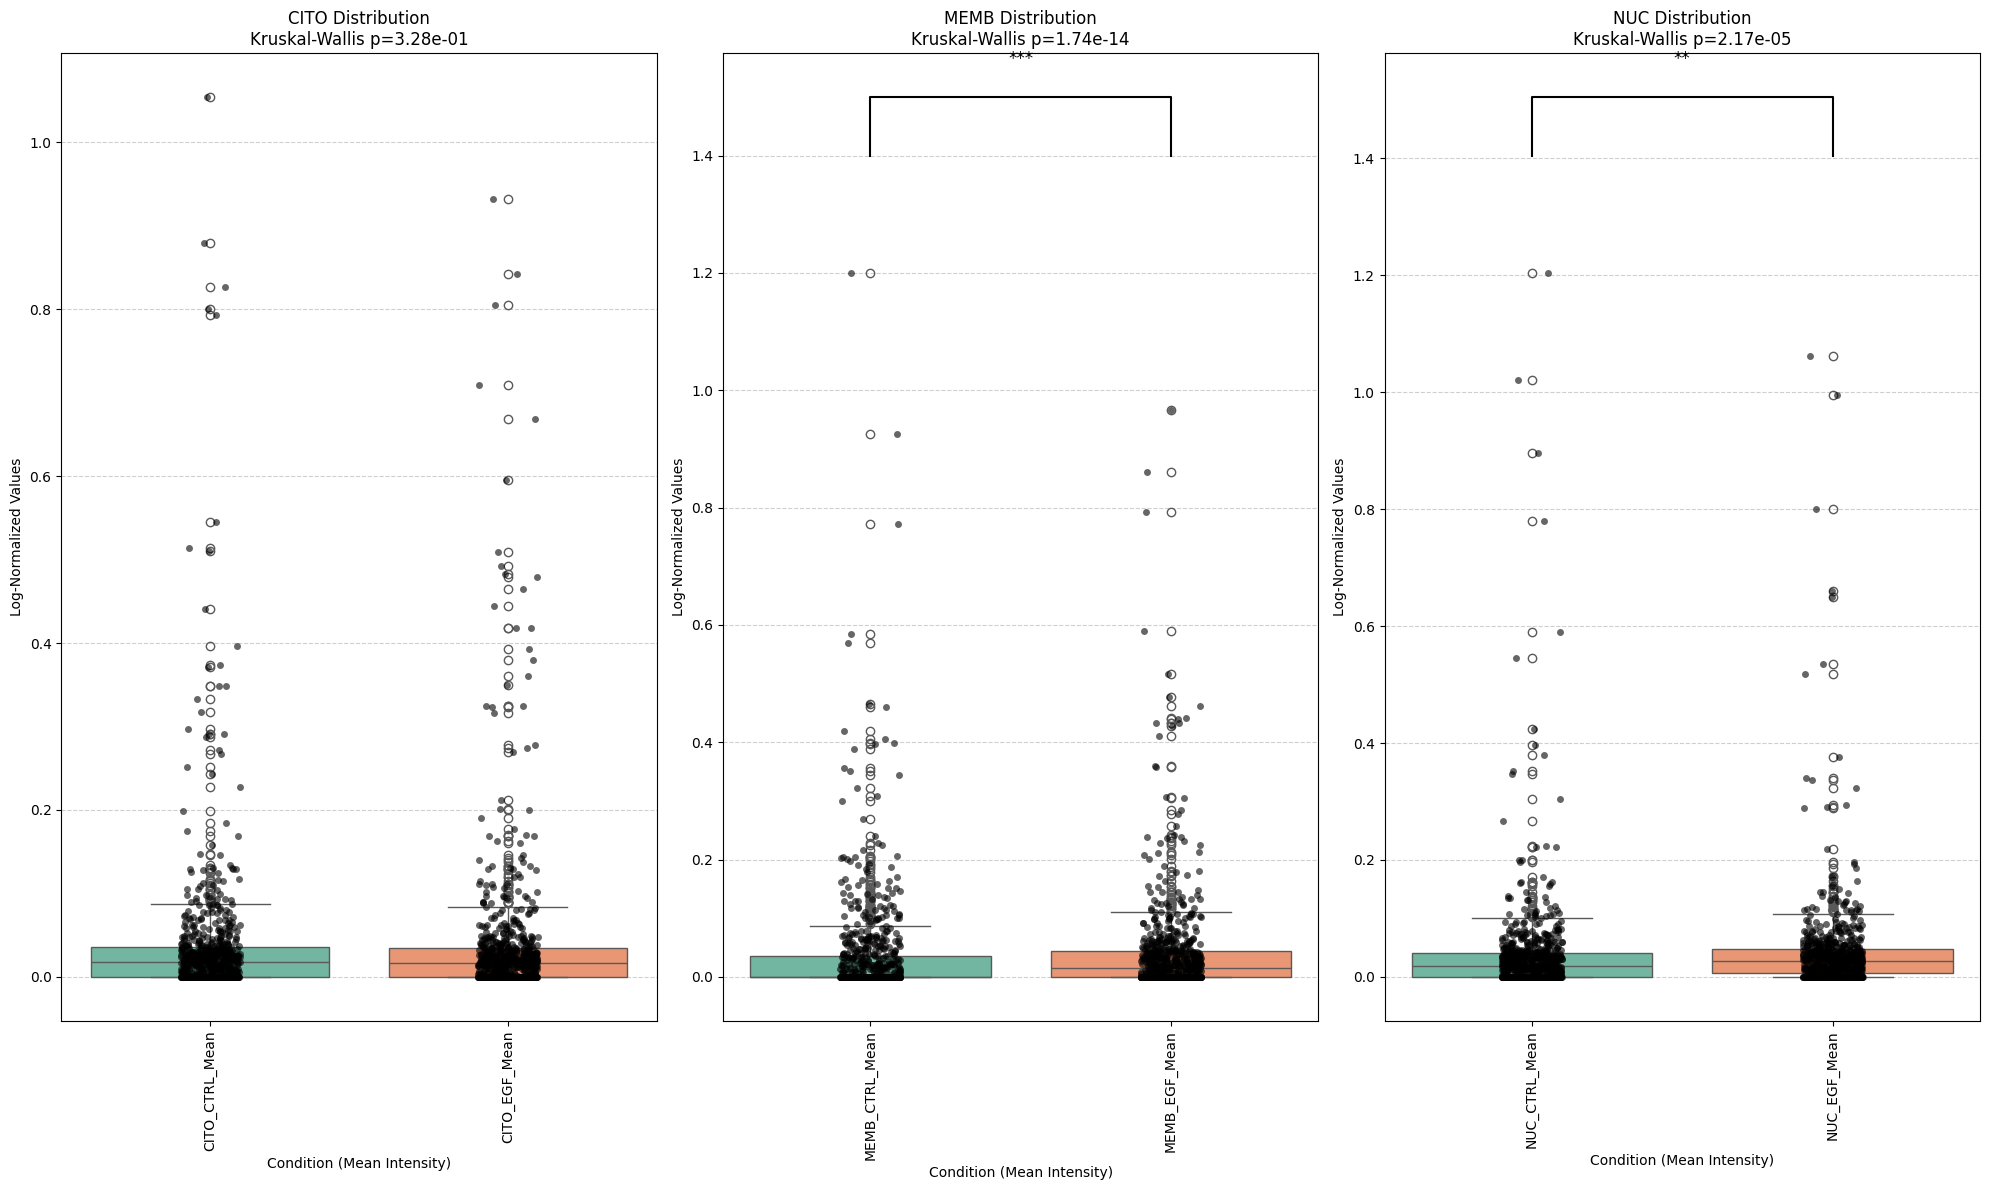

In [27]:
# Function to convert p-values to significance labels
def get_significance_label(pval):
    if pval < 0.001:
        return '***'
    elif pval < 0.01:
        return '**'
    elif pval < 0.05:
        return '*'
    else:
        return 'ns'

# Function to plot boxplots with mean-based data and significance annotations
def plot_boxplots_with_annotations_means(compartments, kruskal_results, dunn_results):
    plt.figure(figsize=(20, 12))  # Adjust figure size for three compartments

    for i, (group, cols) in enumerate(compartments.items(), 1):
        plt.subplot(1, 3, i)  # 1 row, 3 columns for compartments
        data_to_plot = df_mean[cols].melt(var_name='Column', value_name='LogNormalizedValue')

        # Plot box plot with error bars
        sns.boxplot(data=data_to_plot, x='Column', y='LogNormalizedValue', palette='Set2')
        
        # Add individual data points for visibility
        sns.stripplot(data=data_to_plot, x='Column', y='LogNormalizedValue', color='black', alpha=0.6, jitter=True)

        # Kruskal-Wallis p-value annotation
        kw_stat, kw_pval = kruskal_results[group]
        plt.title(f'{group} Distribution\nKruskal-Wallis p={kw_pval:.2e}')
        
        # Dunn's test annotations for specific pairwise comparisons
        if group in dunn_results:
            y_max = data_to_plot['LogNormalizedValue'].max()  # Get max y-value to position annotations
            for (col1, col2), pval in dunn_results[group].items():
                x1, x2 = cols.index(col1), cols.index(col2)
                y = y_max + 0.2  # Adjust spacing for each comparison

                # Draw the annotation line for significant comparisons
                plt.plot([x1, x1, x2, x2], [y, y + 0.1, y + 0.1, y], lw=1.5, color='black')

                # Add significance label
                sig_text = get_significance_label(pval)
                plt.text((x1 + x2) * 0.5, y + 0.15, sig_text, ha='center', va='bottom', color="black", fontsize=12)
                
                # Update y_max for next annotation position
                y_max += 0.4

        # Rotate x labels for better readability using simplified labels
        tick_positions = range(len(cols))  # Set tick positions as the range of column indices
        plt.xticks(tick_positions, labels=cols, rotation=90)
        
        # Labels and grid
        plt.xlabel('Condition (Mean Intensity)')
        plt.ylabel('Log-Normalized Values')
        plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Call the function with the updated data and results
plot_boxplots_with_annotations_means(compartments_mean, kruskal_results, dunn_results)

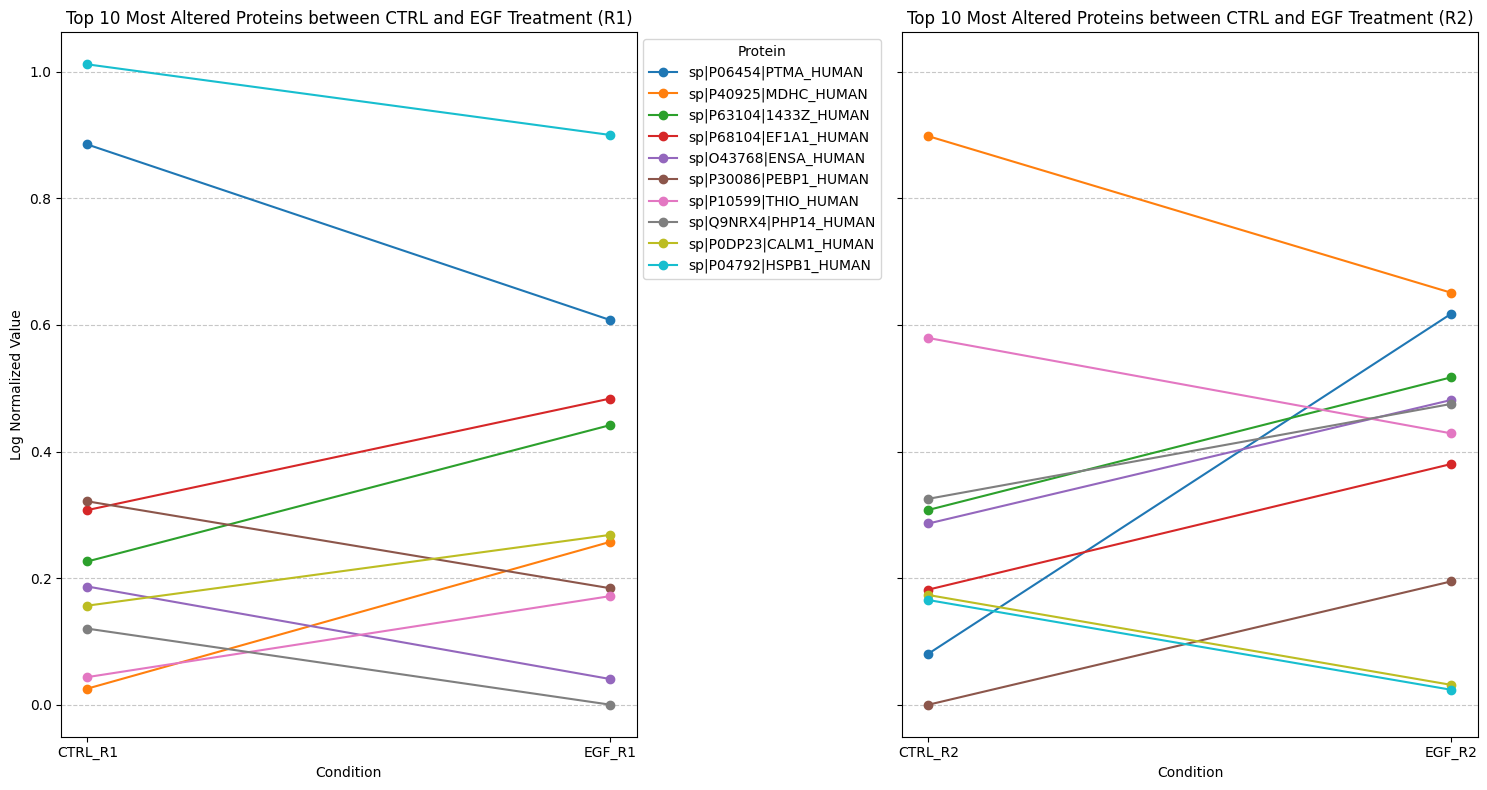

In [28]:
# Calculate absolute differences between _CTRL_ and _EGF_ columns for each replicate
df_differences = pd.DataFrame()
df_differences["Protein"] = df_filtered2_norm_log["Protein"]  # Add protein names for labeling

for col in df_filtered2_norm_log.columns:
    if "_CTRL_" in col and col.endswith("_MaxLFQIntensity"):
        # Find matching _EGF_ column for the same replicate
        egf_col = col.replace("_CTRL_", "_EGF_")
        if egf_col in df_filtered2_norm_log.columns:
            diff_col_name = f"Diff_{col.split('_')[0]}_{col.split('_')[2]}"  # Create a new column for the difference
            df_differences[diff_col_name] = (df_filtered2_norm_log[egf_col] - df_filtered2_norm_log[col]).abs()

# Identify top N proteins with the largest difference in R1 and R2 separately
top_n = 10
most_altered_r1 = df_differences.nlargest(top_n, "Diff_CITO_R1").set_index("Protein")
most_altered_r2 = df_differences.nlargest(top_n, "Diff_CITO_R2").set_index("Protein")

# Plotting the differences for the most altered proteins in separate grids
fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

# Plot for CTRL_R1 vs EGF_R1
for protein in most_altered_r1.index:
    values_r1 = [
        df_filtered2_norm_log.loc[df_filtered2_norm_log['Protein'] == protein, 'CITO_CTRL_R1_MaxLFQIntensity'].values[0],
        df_filtered2_norm_log.loc[df_filtered2_norm_log['Protein'] == protein, 'CITO_EGF_R1_MaxLFQIntensity'].values[0]
    ]
    axs[0].plot(['CTRL_R1', 'EGF_R1'], values_r1, marker='o', label=protein)

# Customize the plot for R1
axs[0].set_title('Top 10 Most Altered Proteins between CTRL and EGF Treatment (R1)')
axs[0].set_xlabel('Condition')
axs[0].set_ylabel('Log Normalized Value')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for CTRL_R2 vs EGF_R2
for protein in most_altered_r2.index:
    values_r2 = [
        df_filtered2_norm_log.loc[df_filtered2_norm_log['Protein'] == protein, 'CITO_CTRL_R2_MaxLFQIntensity'].values[0],
        df_filtered2_norm_log.loc[df_filtered2_norm_log['Protein'] == protein, 'CITO_EGF_R2_MaxLFQIntensity'].values[0]
    ]
    axs[1].plot(['CTRL_R2', 'EGF_R2'], values_r2, marker='o', label=protein)

# Customize the plot for R2
axs[1].set_title('Top 10 Most Altered Proteins between CTRL and EGF Treatment (R2)')
axs[1].set_xlabel('Condition')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].legend(title="Protein", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [34]:
print(df_mean.head())
print(compartments)

                 Protein Protein_ID   Entry_Name      Gene  Protein_Length  \
0   sp|A6NEC2|PSAL_HUMAN     A6NEC2   PSAL_HUMAN  NPEPPSL1           478.0   
1  sp|A8MWD9|RUXGL_HUMAN     A8MWD9  RUXGL_HUMAN  SNRPGP15            76.0   
2  sp|E9PAV3|NACAM_HUMAN     E9PAV3  NACAM_HUMAN      NACA          2078.0   
3  sp|O00148|DX39A_HUMAN     O00148  DX39A_HUMAN    DDX39A           427.0   
4  sp|O00186|STXB3_HUMAN     O00186  STXB3_HUMAN    STXBP3           592.0   

       Organism                            Protein_Existence  \
0  Homo sapiens  2:Experimental evidence at transcript level   
1  Homo sapiens                          5:Protein uncertain   
2  Homo sapiens     1:Experimental evidence at protein level   
3  Homo sapiens     1:Experimental evidence at protein level   
4  Homo sapiens     1:Experimental evidence at protein level   

                                         Description  Protein_Probability  \
0    Puromycin-sensitive aminopeptidase-like protein               0.

In [35]:
# Calculate the difference (log2 fold change) between EGF and CTRL for each compartment
for compartment in compartments:
    # Define the column names for CTRL and EGF mean values for each compartment
    ctrl_mean_col = f'{compartment}_CTRL_Mean'
    egf_mean_col = f'{compartment}_EGF_Mean'
    
    # Calculate the difference (log2 fold change) between EGF and CTRL for each compartment
    df_mean[f'Diff_{compartment}'] = df_mean[egf_mean_col] - df_mean[ctrl_mean_col]
    
    # Calculate the absolute difference for this compartment
    df_mean[f'Abs_Diff_{compartment}'] = df_mean[f'Diff_{compartment}'].abs()

    # Sort by absolute difference for the current compartment
    df_sorted = df_mean.sort_values(by=f'Abs_Diff_{compartment}', ascending=False)

    # Select the top 10 most altered proteins for this compartment
    top_10_proteins = df_sorted.head(10)

    # Display the top 10 most altered proteins for the current compartment
    print(f"Top 10 Most Altered Proteins ({compartment}):")
    print(top_10_proteins[['Protein', f'Diff_{compartment}']].to_string(index=False))
    print("\n")

Top 10 Most Altered Proteins (CITO):
              Protein  Diff_CITO
 sp|P13693|TCTP_HUMAN   0.320538
sp|P63104|1433Z_HUMAN   0.212550
 sp|P06454|PTMA_HUMAN  -0.197416
sp|P68104|EF1A1_HUMAN   0.185756
  sp|P04406|G3P_HUMAN  -0.169739
sp|P0DP23|CALM1_HUMAN   0.155176
 sp|P40925|MDHC_HUMAN   0.143968
 sp|P10599|THIO_HUMAN   0.138971
sp|P04792|HSPB1_HUMAN  -0.122581
sp|P30086|PEBP1_HUMAN  -0.113566


Top 10 Most Altered Proteins (MEMB):
              Protein  Diff_MEMB
sp|P08758|ANXA5_HUMAN  -0.583965
 sp|P62328|TYB4_HUMAN   0.386673
  sp|P14174|MIF_HUMAN   0.361366
sp|P04792|HSPB1_HUMAN  -0.233778
sp|P04075|ALDOA_HUMAN   0.216377
sp|P07355|ANXA2_HUMAN   0.212929
 sp|P01111|RASN_HUMAN   0.207858
sp|P63313|TYB10_HUMAN   0.207689
 sp|P51858|HDGF_HUMAN  -0.205037
sp|Q16777|H2A2C_HUMAN  -0.193654


Top 10 Most Altered Proteins (NUC):
              Protein  Diff_NUC
sp|P08727|K1C19_HUMAN  0.154627
 sp|P05787|K2C8_HUMAN -0.142759
sp|O60814|H2B1K_HUMAN -0.130766
sp|Q96AG4|LRC59_HUMAN  0.123442


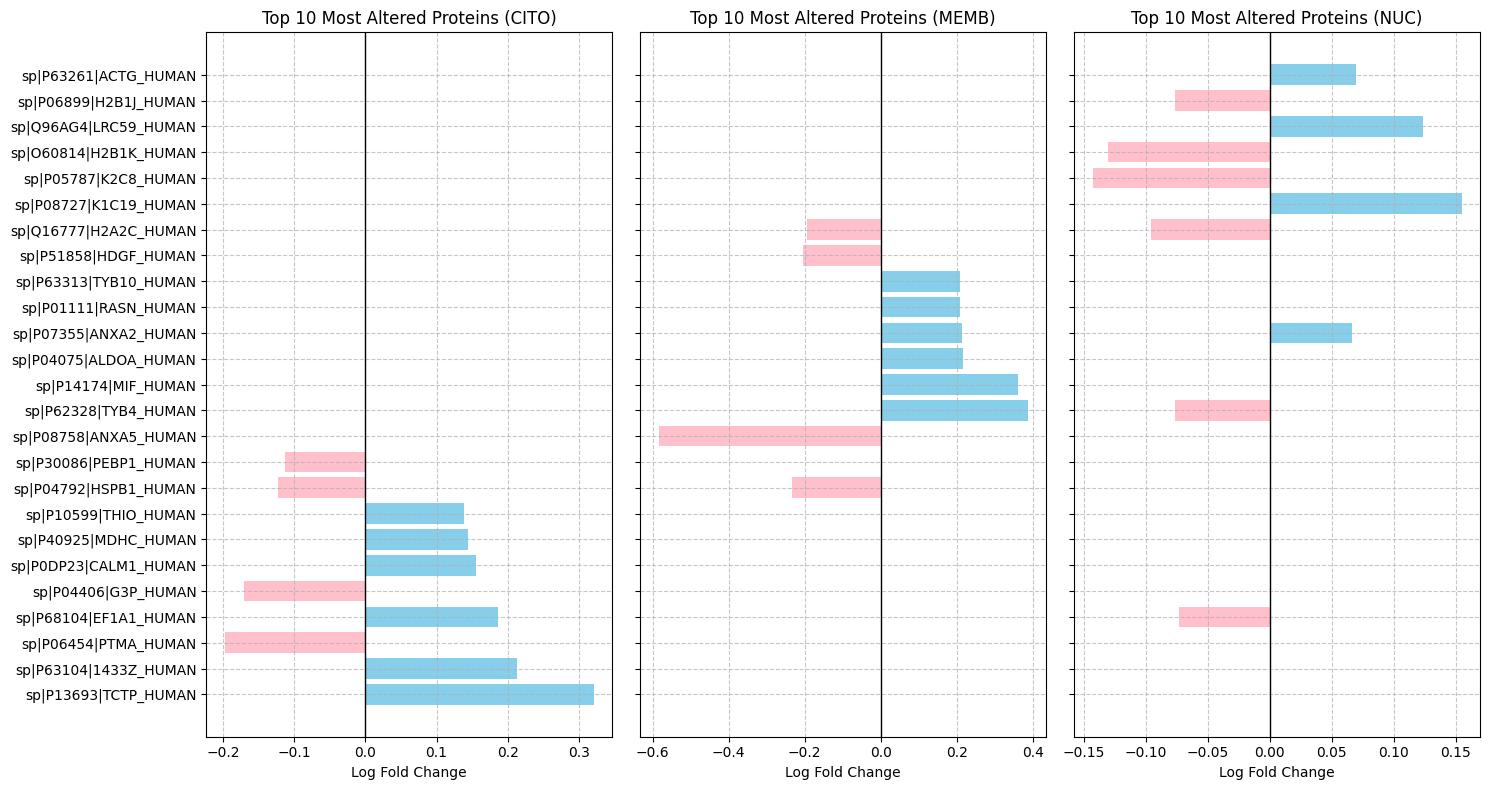

In [38]:
# Plot the top 10 most altered proteins for each compartment
fig, axs = plt.subplots(1, len(compartments), figsize=(15, 8), sharey=True)

for i, compartment in enumerate(compartments):
    # Calculate the top 10 most altered proteins based on absolute difference (already sorted in the previous block)
    top_10_proteins = df_mean.sort_values(by=f'Abs_Diff_{compartment}', ascending=False).head(10)
    
    # Determine colors based on the sign of the fold change
    colors = ['pink' if diff < 0 else 'skyblue' for diff in top_10_proteins[f'Diff_{compartment}']]
    
    # Plot the differences with color indication for positive/negative changes
    axs[i].barh(top_10_proteins['Protein'], top_10_proteins[f'Diff_{compartment}'], color=colors)
    axs[i].set_title(f'Top 10 Most Altered Proteins ({compartment})')
    axs[i].set_xlabel('Log Fold Change')
    axs[i].grid(True, linestyle='--', alpha=0.7)
    # Add a black horizontal line at zero
    axs[i].axvline(x=0, color='black', linewidth=1)

plt.tight_layout()
plt.show()

In [40]:
# Extract columns starting with 'Mean_'
df_mean_columns = df_mean.filter(regex='^.*_Mean$')

# Create the new DataFrame with 'Protein' and the '_Mean' columns
df_mean_columns = df_mean[['Protein']].join(df_mean_columns)

# Show the first few rows of the new DataFrame
print(df_mean_columns.head())

                 Protein  CITO_CTRL_Mean  CITO_EGF_Mean  MEMB_CTRL_Mean  \
0   sp|A6NEC2|PSAL_HUMAN        0.023942       0.029293        0.000000   
1  sp|A8MWD9|RUXGL_HUMAN        0.000000       0.000000        0.000000   
2  sp|E9PAV3|NACAM_HUMAN        0.031831       0.033928        0.011066   
3  sp|O00148|DX39A_HUMAN        0.025842       0.047359        0.011728   
4  sp|O00186|STXB3_HUMAN        0.000000       0.000118        0.000000   

   MEMB_EGF_Mean  NUC_CTRL_Mean  NUC_EGF_Mean  
0       0.000000       0.004193      0.013243  
1       0.000000       0.031259      0.032565  
2       0.040642       0.016244      0.031284  
3       0.021287       0.034835      0.040021  
4       0.033922       0.000000      0.000000  


In [42]:
# Split the mean columns DataFrame by compartments
df_memb_mean = df_mean_columns[['Protein', 'MEMB_CTRL_Mean', 'MEMB_EGF_Mean']]
df_nuc_mean = df_mean_columns[['Protein', 'NUC_CTRL_Mean', 'NUC_EGF_Mean']]
df_cito_mean = df_mean_columns[['Protein', 'CITO_CTRL_Mean', 'CITO_EGF_Mean']]

# Make sure to reset index if you plan to combine data back later
df_memb_mean.reset_index(drop=True, inplace=True)
df_nuc_mean.reset_index(drop=True, inplace=True)
df_cito_mean.reset_index(drop=True, inplace=True)

# Display the first few rows of the DataFrames for each compartment
print('Membrane Mean DataFrame:')
print(df_memb_mean.head())

print('Nucleus Mean DataFrame:')
print(df_nuc_mean.head())

print('Cytosol Mean DataFrame:')
print(df_cito_mean.head())

Membrane Mean DataFrame:
                 Protein  MEMB_CTRL_Mean  MEMB_EGF_Mean
0   sp|A6NEC2|PSAL_HUMAN        0.000000       0.000000
1  sp|A8MWD9|RUXGL_HUMAN        0.000000       0.000000
2  sp|E9PAV3|NACAM_HUMAN        0.011066       0.040642
3  sp|O00148|DX39A_HUMAN        0.011728       0.021287
4  sp|O00186|STXB3_HUMAN        0.000000       0.033922
Nucleus Mean DataFrame:
                 Protein  NUC_CTRL_Mean  NUC_EGF_Mean
0   sp|A6NEC2|PSAL_HUMAN       0.004193      0.013243
1  sp|A8MWD9|RUXGL_HUMAN       0.031259      0.032565
2  sp|E9PAV3|NACAM_HUMAN       0.016244      0.031284
3  sp|O00148|DX39A_HUMAN       0.034835      0.040021
4  sp|O00186|STXB3_HUMAN       0.000000      0.000000
Cytosol Mean DataFrame:
                 Protein  CITO_CTRL_Mean  CITO_EGF_Mean
0   sp|A6NEC2|PSAL_HUMAN        0.023942       0.029293
1  sp|A8MWD9|RUXGL_HUMAN        0.000000       0.000000
2  sp|E9PAV3|NACAM_HUMAN        0.031831       0.033928
3  sp|O00148|DX39A_HUMAN        0.025842   

In [46]:
from scipy.stats import wilcoxon

# Create an empty dictionary to store p-values
p_values = {'MEMB': [], 'NUC': [], 'CITO': []}

# Loop over each compartment and calculate Log2 Fold Change, Wilcoxon test
for compartment, df in zip(['MEMB', 'NUC', 'CITO'], [df_memb_mean, df_nuc_mean, df_cito_mean]):
    
    # Define column names for CTRL and EGF for the current compartment
    ctrl_mean_col = f'{compartment}_CTRL_Mean'
    egf_mean_col = f'{compartment}_EGF_Mean'
    
    # Calculate Log2 Fold Change (LFC) for the current compartment
    df[f'LFC_{compartment}'] = df[egf_mean_col] - df[ctrl_mean_col]
    
    # Perform Wilcoxon signed-rank test for each protein (CTRL vs EGF)
    compartment_p_values = []
    for i, row in df.iterrows():
        # Extract CTRL and EGF values for the current protein and compartment
        ctrl_value = row[ctrl_mean_col]
        egf_value = row[egf_mean_col]
        
        # Perform Wilcoxon signed-rank test (make sure both values are non-zero)
        if ctrl_value > 0 and egf_value > 0:
            stat, p_value = wilcoxon([ctrl_value], [egf_value])
        else:
            p_value = 1  # Assign a non-significant value (1) if no data or both values are zero
        
        # Store the p-value for the current protein and compartment
        compartment_p_values.append(p_value)
    
    # Store p-values in the dictionary for the current compartment
    p_values[compartment] = compartment_p_values
    df[f'P_value_{compartment}'] = p_values[compartment]  # Add p-values to the DataFrame

    # Display Log2 Fold Change and p-values for the compartment
    print(f"Log2 Fold Change (LFC) for {compartment} compartment:")
    print(df[['Protein', f'LFC_{compartment}']].head())
    
    # Sort DataFrame by p-value and select the 10 proteins with the lowest p-values
    top_10_proteins = df.sort_values(by=f'P_value_{compartment}').head(10)
    print(f"\nTop 10 proteins with the lowest p-values for {compartment} compartment:")
    print(top_10_proteins[['Protein', f'LFC_{compartment}', f'P_value_{compartment}']])
    print("\n")

/tmp/ipykernel_56856/1793855164.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'LFC_{compartment}'] = df[egf_mean_col] - df[ctrl_mean_col]
/tmp/ipykernel_56856/1793855164.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'P_value_{compartment}'] = p_values[compartment]  # Add p-values to the DataFrame
/tmp/ipykernel_56856/1793855164.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Log2 Fold Change (LFC) for MEMB compartment:
                 Protein  LFC_MEMB
0   sp|A6NEC2|PSAL_HUMAN  0.000000
1  sp|A8MWD9|RUXGL_HUMAN  0.000000
2  sp|E9PAV3|NACAM_HUMAN  0.029576
3  sp|O00148|DX39A_HUMAN  0.009559
4  sp|O00186|STXB3_HUMAN  0.033922

Top 10 proteins with the lowest p-values for MEMB compartment:
                   Protein  LFC_MEMB  P_value_MEMB
0     sp|A6NEC2|PSAL_HUMAN  0.000000           1.0
457   sp|P62910|RL32_HUMAN  0.000000           1.0
458   sp|P62913|RL11_HUMAN  0.000000           1.0
459    sp|P62917|RL8_HUMAN  0.024907           1.0
460   sp|P62937|PPIA_HUMAN -0.106183           1.0
461  sp|P62942|FKB1A_HUMAN  0.000000           1.0
462  sp|P62979|RS27A_HUMAN  0.058702           1.0
463   sp|P62993|GRB2_HUMAN  0.019784           1.0
464  sp|P62995|TRA2B_HUMAN  0.000000           1.0
465   sp|P63000|RAC1_HUMAN  0.060322           1.0




/tmp/ipykernel_56856/1793855164.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'P_value_{compartment}'] = p_values[compartment]  # Add p-values to the DataFrame
/tmp/ipykernel_56856/1793855164.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'LFC_{compartment}'] = df[egf_mean_col] - df[ctrl_mean_col]


Log2 Fold Change (LFC) for NUC compartment:
                 Protein   LFC_NUC
0   sp|A6NEC2|PSAL_HUMAN  0.009050
1  sp|A8MWD9|RUXGL_HUMAN  0.001306
2  sp|E9PAV3|NACAM_HUMAN  0.015040
3  sp|O00148|DX39A_HUMAN  0.005186
4  sp|O00186|STXB3_HUMAN  0.000000

Top 10 proteins with the lowest p-values for NUC compartment:
                   Protein   LFC_NUC  P_value_NUC
0     sp|A6NEC2|PSAL_HUMAN  0.009050          1.0
457   sp|P62910|RL32_HUMAN  0.005151          1.0
458   sp|P62913|RL11_HUMAN  0.022847          1.0
459    sp|P62917|RL8_HUMAN  0.046920          1.0
460   sp|P62937|PPIA_HUMAN  0.036953          1.0
461  sp|P62942|FKB1A_HUMAN  0.000000          1.0
462  sp|P62979|RS27A_HUMAN  0.010225          1.0
463   sp|P62993|GRB2_HUMAN  0.000000          1.0
464  sp|P62995|TRA2B_HUMAN  0.000000          1.0
465   sp|P63000|RAC1_HUMAN  0.000000          1.0


Log2 Fold Change (LFC) for CITO compartment:
                 Protein  LFC_CITO
0   sp|A6NEC2|PSAL_HUMAN  0.005351
1  sp|A8MWD9|RUX

/tmp/ipykernel_56856/1793855164.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'P_value_{compartment}'] = p_values[compartment]  # Add p-values to the DataFrame


In [48]:
# Add the p-values from the dictionary to the df_mean DataFrame
df_mean['P_value_MEMB'] = p_values['MEMB']
df_mean['P_value_NUC'] = p_values['NUC']
df_mean['P_value_CITO'] = p_values['CITO']

# Loop over each compartment to find the top 10 proteins with the largest LFC
for compartment, df in zip(['MEMB', 'NUC', 'CITO'], [df_memb_mean, df_nuc_mean, df_cito_mean]):
    # Define the corresponding columns for the compartment
    ctrl_mean_col = f'{compartment}_CTRL_Mean'
    egf_mean_col = f'{compartment}_EGF_Mean'
    
    # Sort proteins by the absolute value of Log2 Fold Change (LFC)
    df_sorted = df[['Protein', f'LFC_{compartment}', f'P_value_{compartment}']].copy()
    
    # Calculate the absolute value of LFC for sorting
    df_sorted['Abs_LFC'] = df_sorted[f'LFC_{compartment}'].abs()
    
    # Sort by absolute LFC in descending order to get largest changes
    df_sorted = df_sorted.sort_values(by='Abs_LFC', ascending=False)
    
    # Get the top 10 proteins with the largest LFC (positive or negative)
    top_10_proteins = df_sorted.head(10)
    
    # Display the top 10 proteins with LFC and corresponding p-values
    print(f"Top 10 Proteins with Largest LFC ({compartment} compartment):")
    print(top_10_proteins[['Protein', f'LFC_{compartment}', f'P_value_{compartment}']].to_string(index=False))
    print("\n")

Top 10 Proteins with Largest LFC (MEMB compartment):
              Protein  LFC_MEMB  P_value_MEMB
sp|P08758|ANXA5_HUMAN -0.583965           1.0
 sp|P62328|TYB4_HUMAN  0.386673           1.0
  sp|P14174|MIF_HUMAN  0.361366           1.0
sp|P04792|HSPB1_HUMAN -0.233778           1.0
sp|P04075|ALDOA_HUMAN  0.216377           1.0
sp|P07355|ANXA2_HUMAN  0.212929           1.0
 sp|P01111|RASN_HUMAN  0.207858           1.0
sp|P63313|TYB10_HUMAN  0.207689           1.0
 sp|P51858|HDGF_HUMAN -0.205037           1.0
sp|Q16777|H2A2C_HUMAN -0.193654           1.0


Top 10 Proteins with Largest LFC (NUC compartment):
              Protein   LFC_NUC  P_value_NUC
sp|P08727|K1C19_HUMAN  0.154627          1.0
 sp|P05787|K2C8_HUMAN -0.142759          1.0
sp|O60814|H2B1K_HUMAN -0.130766          1.0
sp|Q96AG4|LRC59_HUMAN  0.123442          1.0
sp|Q16777|H2A2C_HUMAN -0.096036          1.0
sp|P06899|H2B1J_HUMAN -0.076465          1.0
 sp|P62328|TYB4_HUMAN -0.076028          1.0
sp|P68104|EF1A1_HUMAN -0.07

In [57]:
# Create a dictionary to store results
results_dict = {
    'MEMB': {
        'df': df_memb_mean[['Protein', 'LFC_MEMB', 'P_value_MEMB']],
        'top_10': df_memb_mean.sort_values(by='P_value_MEMB').head(10)[['Protein', 'LFC_MEMB', 'P_value_MEMB']]
    },
    'NUC': {
        'df': df_nuc_mean[['Protein', 'LFC_NUC', 'P_value_NUC']],
        'top_10': df_nuc_mean.sort_values(by='P_value_NUC').head(10)[['Protein', 'LFC_NUC', 'P_value_NUC']]
    },
    'CITO': {
        'df': df_cito_mean[['Protein', 'LFC_CITO', 'P_value_CITO']],
        'top_10': df_cito_mean.sort_values(by='P_value_CITO').head(10)[['Protein', 'LFC_CITO', 'P_value_CITO']]
    }
}
results_dict

{'MEMB': {'df':                             Protein  LFC_MEMB  P_value_MEMB
  0              sp|A6NEC2|PSAL_HUMAN  0.000000           1.0
  1             sp|A8MWD9|RUXGL_HUMAN  0.000000           1.0
  2             sp|E9PAV3|NACAM_HUMAN  0.029576           1.0
  3             sp|O00148|DX39A_HUMAN  0.009559           1.0
  4             sp|O00186|STXB3_HUMAN  0.033922           1.0
  ..                              ...       ...           ...
  688            sp|Q9Y4Y9|LSM5_HUMAN  0.020989           1.0
  689           sp|Q9Y5S9|RBM8A_HUMAN  0.000000           1.0
  690            sp|Q9Y624|JAM1_HUMAN  0.007590           1.0
  691           sp|Q9Y696|CLIC4_HUMAN  0.000000           1.0
  692  tr|A0A494BZU2|A0A494BZU2_HUMAN  0.000000           1.0
  
  [693 rows x 3 columns],
  'top_10':                    Protein  LFC_MEMB  P_value_MEMB
  0     sp|A6NEC2|PSAL_HUMAN  0.000000           1.0
  457   sp|P62910|RL32_HUMAN  0.000000           1.0
  458   sp|P62913|RL11_HUMAN  0.000000      

In [75]:
# Find the common proteins across all compartments
common_proteins = set(results_dict['MEMB']['df']['Protein']) & set(results_dict['NUC']['df']['Protein']) & set(results_dict['CITO']['df']['Protein'])

# Create a dictionary to store LFC data for the common proteins
lfc_data = {'Protein': list(common_proteins)}  # Start with the common proteins

# Add LFC values for each compartment, ensuring proteins are aligned
for compartment in ['MEMB', 'NUC', 'CITO']:
    compartment_df = results_dict[compartment]['df']
    # Filter the compartment data to include only common proteins
    compartment_data = compartment_df[compartment_df['Protein'].isin(common_proteins)]
    # Sort by protein to align correctly with the common proteins
    compartment_data = compartment_data.sort_values('Protein')
    lfc_data[compartment] = compartment_data[f'LFC_{compartment}'].values

# Convert the dictionary to a DataFrame for easier manipulation
lfc_df = pd.DataFrame(lfc_data)
print(lfc_df)

                   Protein      MEMB       NUC      CITO
0    sp|Q9NVA2|SEP11_HUMAN  0.000000  0.009050  0.005351
1     sp|P34897|GLYM_HUMAN  0.000000  0.001306  0.000000
2    sp|Q5JWF2|GNAS1_HUMAN  0.029576  0.015040  0.002097
3     sp|P00558|PGK1_HUMAN  0.009559  0.005186  0.021517
4    sp|P62995|TRA2B_HUMAN  0.033922  0.000000  0.000118
..                     ...       ...       ...       ...
688   sp|P06576|ATPB_HUMAN  0.020989  0.015511  0.012200
689  sp|P09467|F16P1_HUMAN  0.000000  0.011691  0.013671
690  sp|P08133|ANXA6_HUMAN  0.007590  0.000000  0.000000
691  sp|P61981|1433G_HUMAN  0.000000  0.000000  0.003631
692   sp|P23588|IF4B_HUMAN  0.000000  0.000000  0.000000

[693 rows x 4 columns]


<Figure size 1000x800 with 0 Axes>

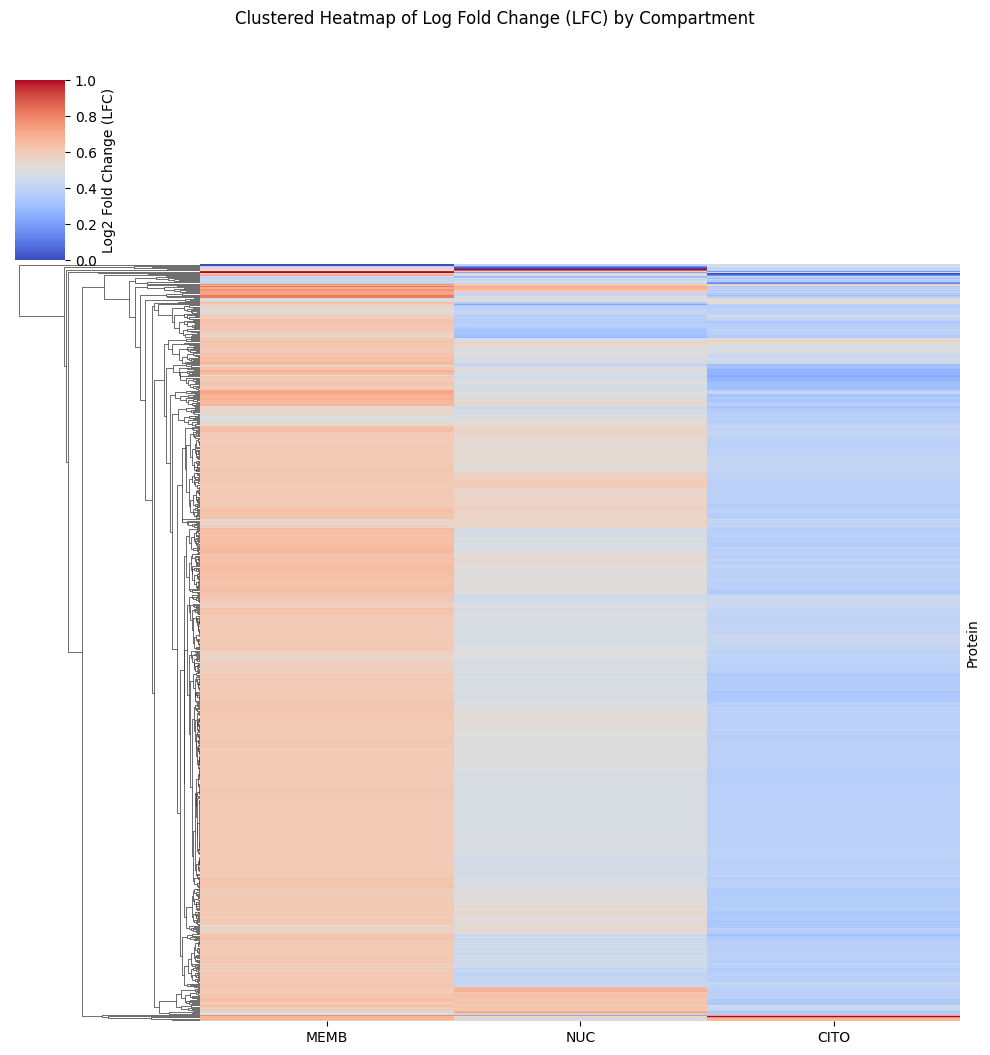

In [76]:
# Ensure the 'Protein' column is set as the index for clustering purposes
lfc_df.set_index('Protein', inplace=True)

# Create a clustered heatmap
plt.figure(figsize=(10, 8))
sns.clustermap(lfc_df, 
               cmap='coolwarm',          # Color map for the heatmap
               metric='euclidean',       # Distance metric for clustering
               method='average',         # Clustering method
               standard_scale=1,         # Scale the data (standardize across rows)
               row_cluster=True,         # Cluster rows (proteins)
               col_cluster=False,        # Don't cluster columns (compartments)
               cbar_kws={'label': 'Log2 Fold Change (LFC)'},  # Colorbar label
               yticklabels=False          # Hide protein names
)

# Customize the title and show the plot
plt.suptitle("Clustered Heatmap of Log Fold Change (LFC) by Compartment", y=1.05)
plt.show()

In [84]:
# Extract and combine the top 10 proteins for each compartment from the results_dict
top_proteins_combined = []

for compartment in results_dict:
    # Extract the 'top_10' DataFrame for each compartment
    top_10_df = results_dict[compartment]['top_10']
    
    # Rename the columns to include the compartment name
    if compartment == 'MEMB':
        top_10_df = top_10_df.rename(columns={'LFC_MEMB': 'Cyt. Membrane'})
    elif compartment == 'NUC':
        top_10_df = top_10_df.rename(columns={'LFC_NUC': 'Nucleus'})
    elif compartment == 'CITO':
        top_10_df = top_10_df.rename(columns={'LFC_CITO': 'Cytosol'})
    
    # Set 'Protein' as the index for each compartment
    top_10_df.set_index('Protein', inplace=True)
    
    # Append the compartment-specific DataFrame to the list
    top_proteins_combined.append(top_10_df)

# Concatenate all top 10 DataFrames into a single DataFrame
top_proteins_df = pd.concat(top_proteins_combined, axis=1)
print(top_proteins_df)

                       Cyt. Membrane  P_value_MEMB   Nucleus  P_value_NUC  \
Protein                                                                     
sp|A6NEC2|PSAL_HUMAN        0.000000           1.0  0.009050          1.0   
sp|P62910|RL32_HUMAN        0.000000           1.0  0.005151          1.0   
sp|P62913|RL11_HUMAN        0.000000           1.0  0.022847          1.0   
sp|P62917|RL8_HUMAN         0.024907           1.0  0.046920          1.0   
sp|P62937|PPIA_HUMAN       -0.106183           1.0  0.036953          1.0   
sp|P62942|FKB1A_HUMAN       0.000000           1.0  0.000000          1.0   
sp|P62979|RS27A_HUMAN       0.058702           1.0  0.010225          1.0   
sp|P62993|GRB2_HUMAN        0.019784           1.0  0.000000          1.0   
sp|P62995|TRA2B_HUMAN       0.000000           1.0  0.000000          1.0   
sp|P63000|RAC1_HUMAN        0.060322           1.0  0.000000          1.0   

                        Cytosol  P_value_CITO  
Protein                    

<Figure size 1000x800 with 0 Axes>

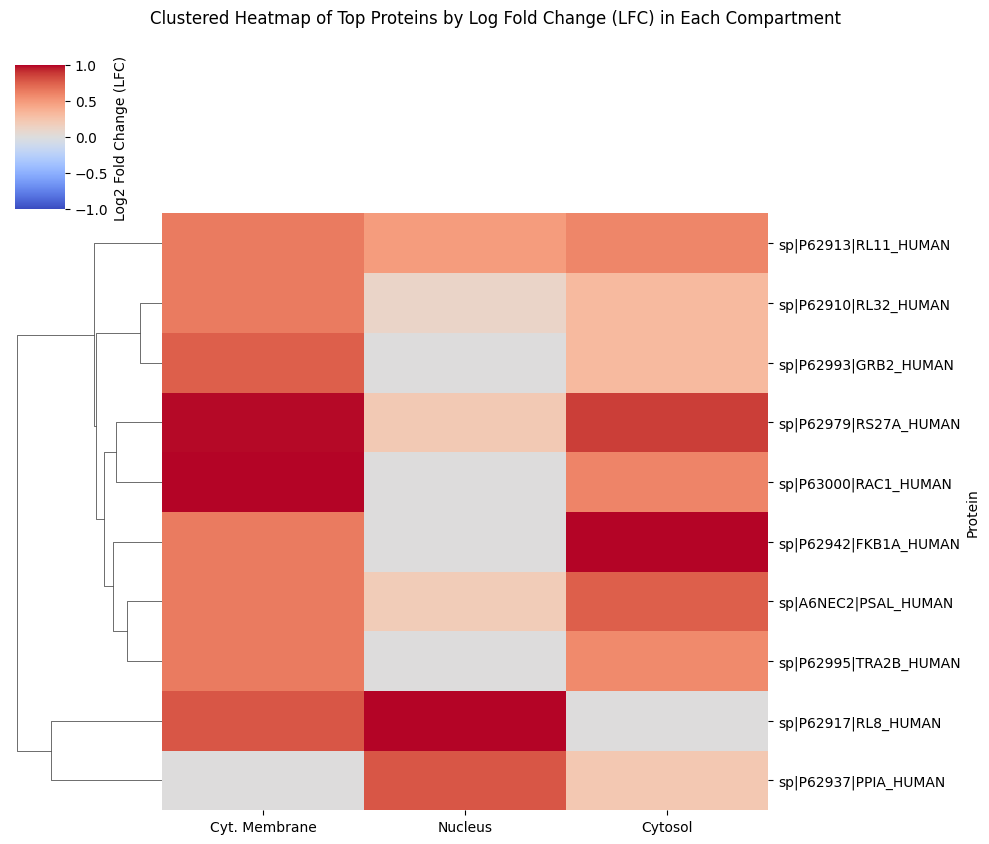

In [85]:
# Filter the DataFrame to include only the LFC columns (excluding P_value columns)
top_proteins_lfc_df = top_proteins_df[['Cyt. Membrane', 'Nucleus', 'Cytosol']]

# Create a clustered heatmap for the selected proteins
plt.figure(figsize=(10, 8))
sns.clustermap(
    top_proteins_lfc_df,  # Use the LFC data for heatmap
    cmap='coolwarm',      # Color map for the heatmap
    metric='euclidean',   # Distance metric for clustering
    method='average',     # Clustering method
    standard_scale=1,     # Standardize across rows
    row_cluster=True,     # Cluster rows (proteins)
    col_cluster=False,    # Don't cluster columns (compartments)
    cbar_kws={'label': 'Log2 Fold Change (LFC)'},  # Colorbar label
    vmin=-1, vmax=1,      # Set the color scale to range from -1 to 1
    yticklabels=True,     # Show protein names on the y-axis
    figsize=(10, 8)       # Control the figure size
)

# Customize the title and show the plot
plt.suptitle("Clustered Heatmap of Top Proteins by Log Fold Change (LFC) in Each Compartment", y=1.05)
plt.show()
